# Prepare Merging

In [2]:
import scanpy as sc
import os
import gzip
import shutil
from tqdm.notebook import tqdm
import anndata
import matplotlib.pyplot as plt
import helpers_danielstrobel
from IPython.display import Image
import numpy as np
import seaborn as sns
from scipy.stats import median_abs_deviation
import anndata2ri
import logging
import scrublet
import pandas as pd
import utils


import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro


rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)
plt.rcParams['figure.figsize'] = (9, 9)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Load and Merge raw data

In [3]:
path = "GSE129605"

In [4]:
adata_raw = {}
for folder in tqdm(os.listdir(path)):
    adata_raw[folder] = sc.read_10x_mtx(os.path.join(path, folder))

  0%|          | 0/11 [00:00<?, ?it/s]

In [5]:
adata_raw = anndata.concat(adata_raw, label="samples")

/Users/leahollenberg/Desktop/Masterpraktikum/PycharmProjects/scanpy_start/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [6]:
adata_raw.obs[['GSM', 'tmp']] = adata_raw.obs['samples'].str.split("_", expand = True)
adata_raw.obs[['condition', 'id']] = adata_raw.obs['tmp'].str.split(".", expand = True)
adata_raw.obs.drop(columns=['tmp'], inplace=True)
adata_raw.obs

,samples,GSM,condition,id
AAACCTGAGGAATTAC-1,GSM3716976_saline.947170,GSM3716976,saline,947170
AAACCTGCATAACCTG-1,GSM3716976_saline.947170,GSM3716976,saline,947170
AAACCTGCATTGGGCC-1,GSM3716976_saline.947170,GSM3716976,saline,947170
AAACCTGGTCTCAACA-1,GSM3716976_saline.947170,GSM3716976,saline,947170
AAACCTGGTTGACGTT-1,GSM3716976_saline.947170,GSM3716976,saline,947170
...,...,...,...,...
TTTGCGCCAGACAAGC-1,GSM3716985_nintedanib.947178,GSM3716985,nintedanib,947178
TTTGCGCGTCATATGC-1,GSM3716985_nintedanib.947178,GSM3716985,nintedanib,947178
TTTGCGCGTCCGAATT-1,GSM3716985_nintedanib.947178,GSM3716985,nintedanib,947178
TTTGGTTGTAGCTTGT-1,GSM3716985_nintedanib.947178,GSM3716985,nintedanib,947178


In [7]:
adata_raw.var_names_make_unique()
adata_raw.obs_names_make_unique()
adata_raw

AnnData object with n_obs × n_vars = 18975 × 25127
    obs: 'samples', 'GSM', 'condition', 'id'

In [8]:
# Raw Counts in einem separaten Layer speichern
adata_raw.layers["raw"] = adata_raw.X.copy()

## Quality Control

In [10]:
# mitochondrial genes
adata_raw.var["mt"] = adata_raw.var_names.str.startswith("MT-", "mt-")
# ribosomal genes
adata_raw.var["ribo"] = adata_raw.var_names.str.startswith(("RPS", "RPL", "rps", "rpl"))
# hemoglobin genes.
adata_raw.var["hb"] = adata_raw.var_names.str.contains(("^HB[^(P)]|^hb[^(p)]"))

In [11]:
sc.pp.calculate_qc_metrics(
    adata_raw, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata_raw

AnnData object with n_obs × n_vars = 18975 × 25127
    obs: 'samples', 'GSM', 'condition', 'id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'raw'

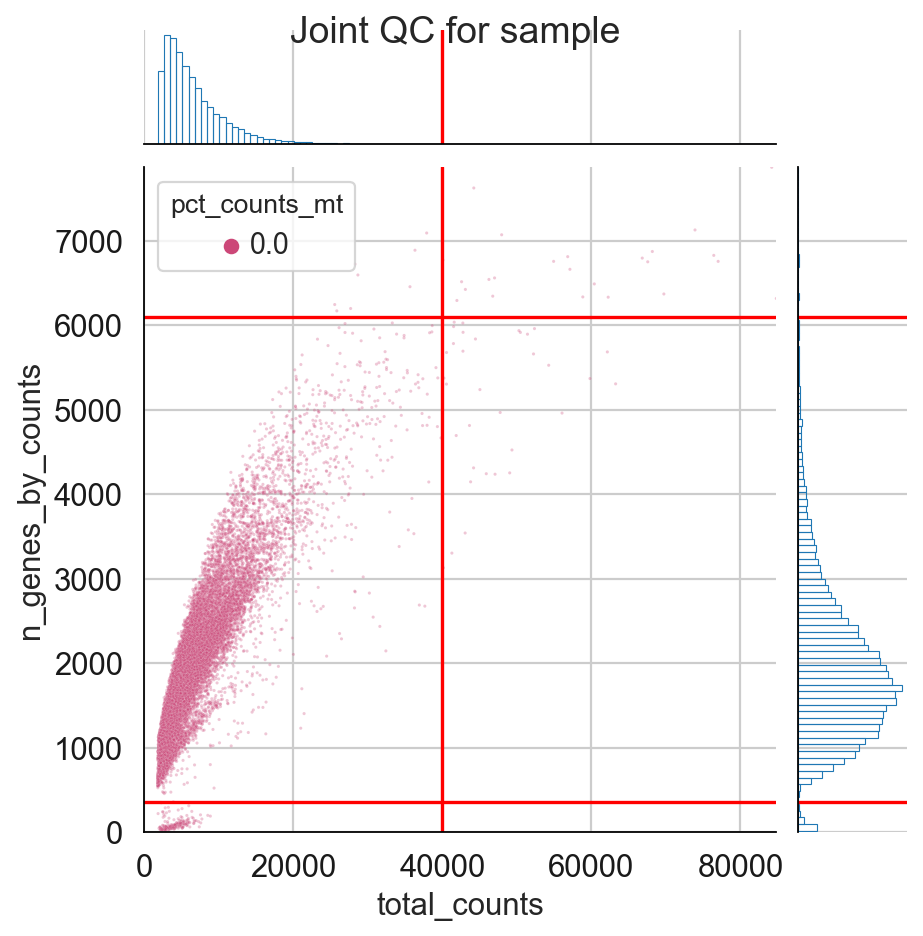

In [12]:
utils.plot_qc_joint(adata_raw, x="total_counts",
                    y='n_genes_by_counts',
                    hue='pct_counts_mt',
                    palette='plasma',
                    x_threshold=(350, 6100),  # total_counts
                    y_threshold=(0, 40000),  # n_genes_by_counts
                    title='Joint QC for sample ')

In [13]:
print("Number of genes in data before filtering: ", adata_raw.n_vars)
print("Number of cells in data before filtering: ", adata_raw.n_obs)

sc.pp.filter_cells(adata_raw, min_genes=350)
sc.pp.filter_cells(adata_raw, max_genes=6100)
sc.pp.filter_cells(adata_raw, max_counts=40000)
sc.pp.filter_genes(adata_raw, min_counts=1)

print("Number of genes in filtered data: ", adata_raw.n_vars)
print("Number of cells in filtered data: ", adata_raw.n_obs)

Number of genes in data before filtering:  25127
Number of cells in data before filtering:  18975
Number of genes in filtered data:  19472
Number of cells in filtered data:  18686


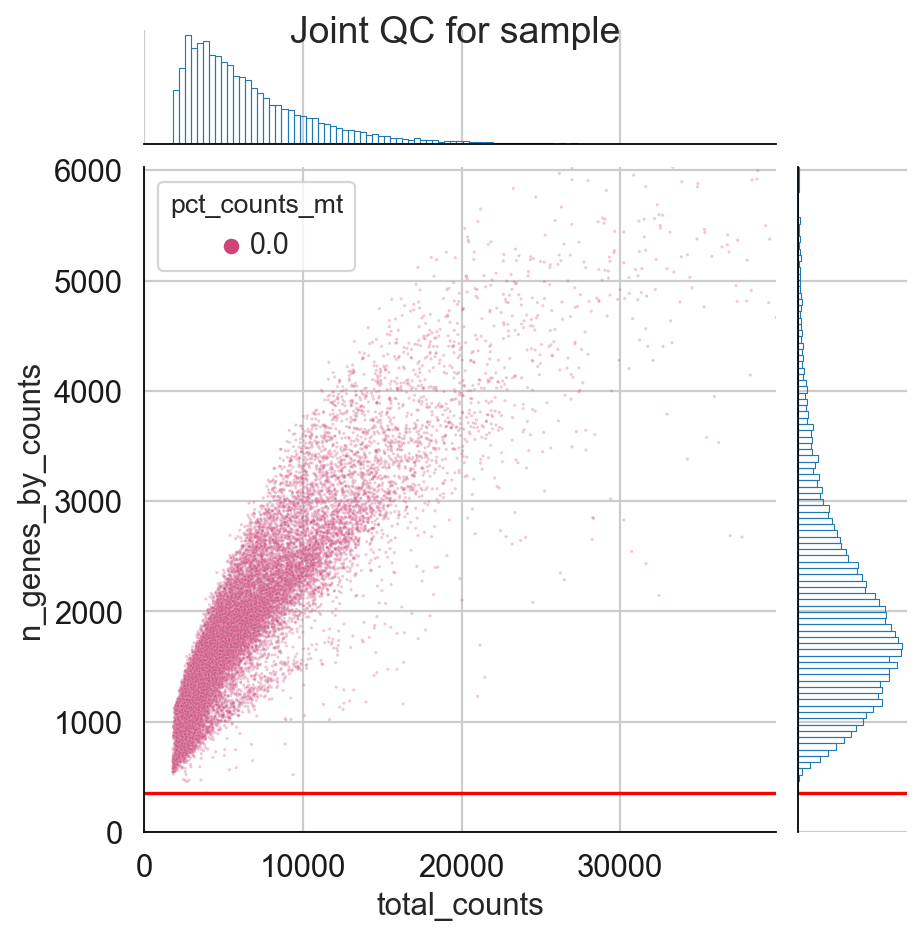

In [14]:
# plot after selection
utils.plot_qc_joint(adata_raw, x="total_counts",
                    y='n_genes_by_counts',
                    hue='pct_counts_mt',
                    palette='plasma',
                    x_threshold=(350, 6100),  # total_counts
                    y_threshold=(0, 40000),  # n_genes_by_counts
                    title='Joint QC for sample ')

In [15]:
adata_raw.write("data/Peyser_raw_QC.h5ad")

In [44]:
adata = sc.read("data/Peyser_raw_QC.h5ad")

In [45]:
adata.X = adata.layers["raw"]
adata.layers.pop("raw")

<18686x19472 sparse matrix of type '<class 'numpy.float32'>'
	with 36718213 stored elements in Compressed Sparse Row format>

In [46]:
adata.obs

,samples,GSM,condition,id,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,n_genes,n_counts
AAACCTGAGGAATTAC-1,GSM3716976_saline.947170,GSM3716976,saline,947170,1158,7.055313,2729.0,7.912057,22.792232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1158,2729.0
AAACCTGCATAACCTG-1,GSM3716976_saline.947170,GSM3716976,saline,947170,1526,7.331060,6030.0,8.704668,23.598673,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1526,6030.0
AAACCTGCATTGGGCC-1,GSM3716976_saline.947170,GSM3716976,saline,947170,2115,7.657283,5689.0,8.646465,19.968360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2115,5689.0
AAACCTGGTCTCAACA-1,GSM3716976_saline.947170,GSM3716976,saline,947170,2395,7.781556,8031.0,8.991189,28.066243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2395,8031.0
AAACCTGGTTGACGTT-1,GSM3716976_saline.947170,GSM3716976,saline,947170,1154,7.051856,2060.0,7.630947,18.203883,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1154,2060.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGCGCCAGACAAGC-1,GSM3716985_nintedanib.947178,GSM3716985,nintedanib,947178,2766,7.925519,13438.0,9.505917,35.280548,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2766,13438.0
TTTGCGCGTCATATGC-1,GSM3716985_nintedanib.947178,GSM3716985,nintedanib,947178,1273,7.149917,3268.0,8.092239,30.293758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1273,3268.0
TTTGCGCGTCCGAATT-1,GSM3716985_nintedanib.947178,GSM3716985,nintedanib,947178,1472,7.295056,4342.0,8.376321,19.345924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1472,4342.0
TTTGGTTGTAGCTTGT-1,GSM3716985_nintedanib.947178,GSM3716985,nintedanib,947178,1673,7.422971,5851.0,8.674539,20.133311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1673,5851.0


In [47]:
keep_columns = ['samples', 'condition']
adata.obs = adata.obs[keep_columns]
adata.obs.rename(columns={'samples': 'batch'}, inplace=True)


/var/folders/ml/y3pzkyx97vzbkxbp2znpbw080000gn/T/ipykernel_23557/2703368949.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.rename(columns={'samples': 'batch'}, inplace=True)


In [48]:
adata.obs

,batch,condition
AAACCTGAGGAATTAC-1,GSM3716976_saline.947170,saline
AAACCTGCATAACCTG-1,GSM3716976_saline.947170,saline
AAACCTGCATTGGGCC-1,GSM3716976_saline.947170,saline
AAACCTGGTCTCAACA-1,GSM3716976_saline.947170,saline
AAACCTGGTTGACGTT-1,GSM3716976_saline.947170,saline
...,...,...
TTTGCGCCAGACAAGC-1,GSM3716985_nintedanib.947178,nintedanib
TTTGCGCGTCATATGC-1,GSM3716985_nintedanib.947178,nintedanib
TTTGCGCGTCCGAATT-1,GSM3716985_nintedanib.947178,nintedanib
TTTGGTTGTAGCTTGT-1,GSM3716985_nintedanib.947178,nintedanib


In [49]:
# add annotation
adata_annotated = sc.read("/Users/leahollenberg/Desktop/adata_annotated.h5ad")
adata_annotated.obs.rename(columns={'manual_celltype_annotation_precise': 'manual_celltype_annotation'}, inplace=True)

In [50]:
adata.obs = adata.obs.join(adata_annotated.obs['manual_celltype_annotation'])


In [51]:
adata.obs

,batch,condition,manual_celltype_annotation
AAACCTGAGGAATTAC-1,GSM3716976_saline.947170,saline,Interstitial Macrophage
AAACCTGCATAACCTG-1,GSM3716976_saline.947170,saline,B-cells
AAACCTGCATTGGGCC-1,GSM3716976_saline.947170,saline,Lymphatic endothelial
AAACCTGGTCTCAACA-1,GSM3716976_saline.947170,saline,Alveolar macrophages
AAACCTGGTTGACGTT-1,GSM3716976_saline.947170,saline,Endothelial
...,...,...,...
TTTGCGCCAGACAAGC-1,GSM3716985_nintedanib.947178,nintedanib,Interstitial Macrophage
TTTGCGCGTCATATGC-1,GSM3716985_nintedanib.947178,nintedanib,Interstitial Macrophage
TTTGCGCGTCCGAATT-1,GSM3716985_nintedanib.947178,nintedanib,Classical monocytes
TTTGGTTGTAGCTTGT-1,GSM3716985_nintedanib.947178,nintedanib,B-cells


In [52]:
adata.write("data/Peyser_Merging.h5ad")